In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.75)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
from gpytorch.lazy import DiagLazyTensor


def conformal_gp_regression(gp, test_inputs, target_grid, alpha):
    """
    Full conformal Bayes for exact GP regression.
    Args:
        gp (gpytorch.models.GP)
        inputs (torch.Tensor): (num_test, input_dim)
        target_grid (torch.Tensor): (grid_size, target_dim)
        alpha (float)
    Returns:
        conf_pred_mask (torch.Tensor): (num_test, grid_size)
    """
    # retraining: condition the GP at every target grid point for every test input
    expanded_inputs = test_inputs.expand(
        target_grid.shape[0], 1, -1, -1
    )
    expanded_inputs = expanded_inputs.permute(
        2, 0, 1, 3
    )  # (num_test, grid_size, 1, input_dim)
    expanded_targets = target_grid.expand(
        test_inputs.shape[0], 1, -1, -1
    )
    expanded_targets = expanded_targets.permute(
        0, 2, 1, 3
    ) # (num_test, grid_size, 1, input_dim)
    updated_gps = gp.condition_on_observations(expanded_inputs, expanded_targets)
    
    # get ready to compute the conformal scores
    train_inputs = updated_gps.train_inputs[0]
    train_labels = updated_gps.prediction_strategy.train_labels
    train_labels = train_labels.unsqueeze(-1)  # (num_test, grid_size, num_train + 1, target_dim)
    lik_train_train_covar = updated_gps.prediction_strategy.lik_train_train_covar
    prior_mean = updated_gps.prediction_strategy.train_prior_dist.mean.unsqueeze(-1)
    prior_covar = updated_gps.prediction_strategy.train_prior_dist.lazy_covariance_matrix
    noise = updated_gps.likelihood.noise
    
    # compute conformal scores (posterior predictive log-likelihood)
    eig_vals, eig_vecs = prior_covar.symeig(eigenvectors=True)  # Q \Lambda Q^{-1} = K_{XX}
    diag_term = DiagLazyTensor(eig_vals / (eig_vals + noise))  # \Lambda (\Lambda + \sigma I)^{-1}
    lhs = eig_vecs @ diag_term
    mean_rhs = eig_vecs.transpose(-1, -2) @ (train_labels - prior_mean)
    pred_mean = (prior_mean + lhs @ mean_rhs).squeeze(-1)
    covar_rhs = DiagLazyTensor(eig_vals) @ eig_vecs.transpose(-1, -2)
    pred_covar = prior_covar - (lhs @ covar_rhs)
    pred_var = (pred_covar.diag() + noise).clamp(min=1e-6)
    pred_dist = torch.distributions.Normal(pred_mean, pred_var.sqrt())
    conf_scores = pred_dist.log_prob(train_labels.squeeze(-1))
    
    # get conformal prediction mask
    sorted_scores, indices = torch.sort(conf_scores, dim=-1)  # larger scores are better
    ranks_by_score = torch.argsort(indices, dim=-1)  # trick: ranks = argsort applied twice
    num_total = conf_scores.shape[-1]
    norm_ranks = (ranks_by_score.float() + 1) / num_total
    conf_pred_mask = norm_ranks[..., -1] > alpha

    # plot train predictions as sanity check
#     sort_idx = train_inputs[0, 0].argsort(dim=0).cpu()
#     plot_inputs = train_inputs[0, 0, sort_idx].cpu().view(-1)
#     plot_targets = train_labels[0, 0, sort_idx].cpu().view(-1)
#     plot_mean = pred_mean[0, 0, sort_idx].cpu().view(-1)
#     plot_std = pred_var[0, 0, sort_idx].sqrt().cpu().view(-1)
#     plot_lb = plot_mean - 1.96 * plot_std
#     plot_ub = plot_mean + 1.96 * plot_std
#     plt.scatter(plot_inputs, plot_targets, color='black')
#     plt.plot(plot_inputs, plot_mean)
#     plt.fill_between(plot_inputs, plot_lb, plot_ub, alpha=0.25)
    
    return conf_pred_mask

In [3]:
# def conformal_ei()

In [4]:
obj_fn = lambda x: np.maximum(-0.125 * x ** 2 + 16 * np.sin(x), 0)

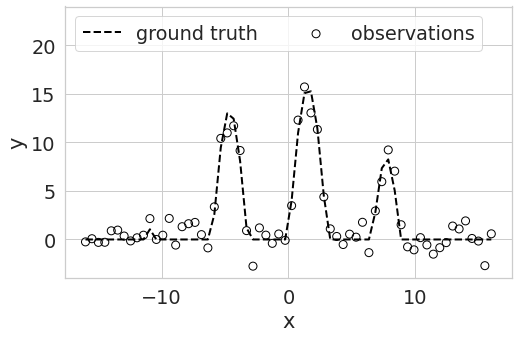

In [5]:
fig = plt.figure(figsize=(8, 5))

noise_scale = 1.
x_bounds = torch.tensor((-16., 16.)).view(-1, 1)

x = np.linspace(*x_bounds, 64)
f = obj_fn(x)
y = f + noise_scale * np.random.randn(*f.shape)

plt.scatter(x, y, edgecolors='black', facecolors='none', label='observations', s=64, zorder=3)
plt.plot(x, f, color='black', linestyle='--', label='ground truth', linewidth=2, zorder=2)

plt.ylabel('y')
plt.xlabel('x')
plt.ylim((-4, 24))
plt.legend(loc='upper left', ncol=2)

In [6]:
import botorch
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from botorch.optim.optimize import optimize_acqf

from gpytorch.mlls import ExactMarginalLogLikelihood

In [7]:
def draw_plot(ax):
    # plot p(f | x, D)
    ax.plot(all_inputs.cpu(), f_hat_mean, color='blue', linewidth=2, zorder=4, label='p(f | x, D)')
    ax.fill_between(all_inputs.view(-1).cpu(), f_hat_mean - 1.96 * f_hat_std, f_hat_mean + 1.96 * f_hat_std,
                    color='blue', alpha=0.25)

    # plot a(x)
    ax.plot(all_inputs.cpu(), acq_vals, color='green', zorder=5, linewidth=2, label='a(x)')
    ax.scatter(input_query.cpu(), target_query.cpu(), marker='x', color='red', label='x*', zorder=5,
               s=32, linewidth=2)

    # plot observed
    ax.scatter(train_inputs.cpu(), train_targets.cpu(), edgecolors='black', facecolors='black',
               label='D', s=32, zorder=3)
    # plot unobserved
#     plt.scatter(all_inputs, all_targets,
#                 edgecolors='black', facecolors='none', label='unobserved', s=32, zorder=3)

    # plot true function
    ax.plot(all_inputs.cpu(), y_norm(f), color='black', linestyle='--', label='f')

    # plot training cutoff
    # plt.vlines((-8 - x_loc) / x_scale, *plt.ylim(), color='red', linestyle='--')

    ax.set_ylim((-2., 2.))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    return ax

In [8]:
from lambo.utils import DataSplit, update_splits
from lambo.optimizers.pymoo import Normalizer

cutoff = np.max(np.where(x < -8))
x_min, y_min = x.min(0), y.min(0)
x_range, y_range = x.max(0) - x_min, y.max(0) - y_min

x_norm = Normalizer(
    loc=x_min + 0.5 * x_range,
    scale=x_range / 2.,
)
y_norm = Normalizer(
    loc=y_min + 0.5 * y_range,
    scale=y_range / 2.,
)

train_x = x[:cutoff]
# x_loc = train_x.mean(0)
# x_scale = train_x.std(0)

train_y = y[:cutoff]
# y_loc = train_y.mean(0)
# y_scale = train_y.std(0)

# all_inputs = torch.tensor(
#     (x - x_loc) / x_scale
# ).view(-1, 1)
# all_targets = torch.tensor(
#     (y - y_loc) / y_scale
# ).view(-1, 1)

all_inputs = torch.tensor(x_norm(x), device=DEVICE).view(-1, 1)
all_targets = torch.tensor(y_norm(y), device=DEVICE).view(-1, 1)
target_dim = all_targets.shape[-1]

new_split = DataSplit(
    all_inputs[:cutoff].cpu().numpy(), all_targets[:cutoff].cpu().numpy()
)
train_split, val_split, test_split = update_splits(
    train_split=DataSplit(),
    val_split=DataSplit(),
    test_split=DataSplit(),
    new_split=new_split,
    holdout_ratio=0.2
)

input_bounds = torch.tensor([-1., 1.], device=DEVICE).view(-1, 1)

11 train, 3 val, 1 test
16 train, 3 val, 4 test
20 train, 6 val, 5 test
28 train, 6 val, 5 test


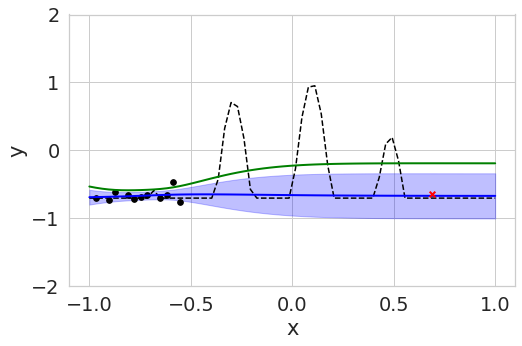

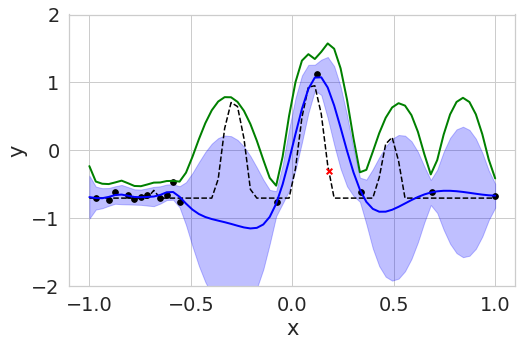

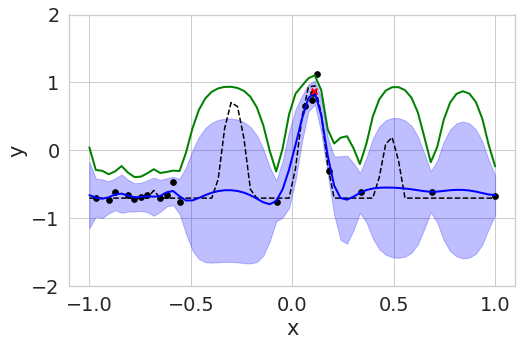

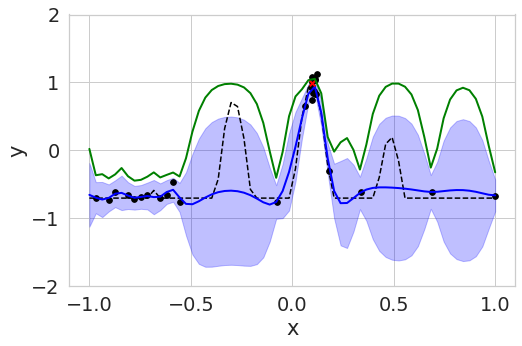

In [9]:
num_rounds = 32
plot_interval = 8

for round_idx in range(num_rounds):
    train_inputs = torch.tensor(train_split[0], device=DEVICE)
    train_targets = torch.tensor(train_split[1], device=DEVICE)
    
    matern_gp = botorch.models.SingleTaskGP(train_inputs, train_targets).to(DEVICE)
    mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
    fit_gpytorch_model(mll)
    acq_fn = UpperConfidenceBound(matern_gp, beta=8.)
#     acq_fn = ExpectedImprovement(matern_gp, best_f=train_targets.max())
    
    matern_gp.eval()
    with torch.no_grad():
        f_hat_dist = matern_gp(all_inputs)
        y_hat_dist = matern_gp.likelihood(f_hat_dist)
        f_hat_mean = f_hat_dist.mean.cpu()
        f_hat_std = f_hat_dist.variance.sqrt().cpu()
        y_hat_mean = f_hat_mean.cpu()
        y_hat_std = y_hat_dist.variance.sqrt().cpu()
        acq_vals = acq_fn(all_inputs[:, None]).cpu()
        
    input_query = optimize_acqf(acq_fn, input_bounds, 1, num_restarts=4, raw_samples=16)[0]
    x_query = x_norm.inv_transform(input_query.cpu().numpy())
    f_query = obj_fn(x_query)
    y_query = f_query + noise_scale * np.random.randn(*f_query.shape)
    target_query = torch.tensor(y_norm(y_query), device=DEVICE)
    
    if round_idx % plot_interval == 0:
        print(f'{train_split[0].shape[0]} train, {val_split[0].shape[0]} val, {test_split[0].shape[0]} test')
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(1, 1, 1)
        draw_plot(ax)
    #     plt.close()
    
    new_split = DataSplit(
        input_query.reshape(-1, 1).cpu(),
        target_query.reshape(-1, 1).cpu(),
    )
    train_split, val_split, test_split = update_splits(
        train_split, val_split, test_split, new_split, holdout_ratio=0.2
    )


In [10]:
cvrg_level = 0.95
alpha = 1 - cvrg_level

val_inputs = torch.tensor(
    np.concatenate([val_split[0], test_split[0]]), device=DEVICE
)
val_targets = torch.tensor(
    np.concatenate([val_split[1], test_split[1]]), device=DEVICE
)

val_inputs, indices = torch.sort(val_inputs, dim=0)
val_targets = val_targets[indices]

# note: grid_size = target_grid_res ** target_dim
target_grid_res = 32
grid_coords = [np.linspace(-2., 2., target_grid_res) for _ in range(target_dim)]
target_grid = np.stack(np.meshgrid(*grid_coords), axis=-1)
target_grid = torch.tensor(target_grid).view(-1, target_dim)
target_grid = target_grid.to(val_inputs)

conf_pred_mask = conformal_gp_regression(matern_gp, val_inputs, target_grid, alpha)

In [11]:
conf_pred_mask.requires_grad

False

In [12]:
# convert conformal prediction mask to prediction set
masked_targets = conf_pred_mask.to(target_grid).unsqueeze(-1) * target_grid
conf_ub = masked_targets.max(-2)[0].cpu().view(-1)
conf_lb = -1 * (-masked_targets).max(-2)[0].cpu().view(-1)
conf_mid = ((conf_ub + conf_lb) / 2.).cpu().view(-1)

# get standard GP credible interval
with torch.no_grad():
    f_hat_dist = matern_gp(val_inputs)
    y_hat_dist = matern_gp.likelihood(f_hat_dist)
    f_hat_mean = f_hat_dist.mean.cpu()
    f_hat_std = f_hat_dist.variance.sqrt().cpu()
    y_hat_mean = f_hat_mean.cpu()
    y_hat_std = y_hat_dist.variance.sqrt().cpu()
cred_lb = y_hat_mean - 1.96 * y_hat_std
cred_ub = y_hat_mean + 1.96 * y_hat_std

(-3.0, 3.0)

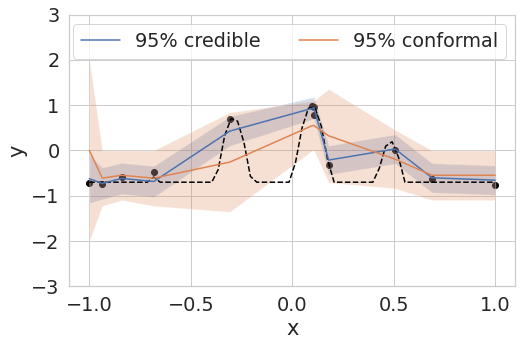

In [13]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# plot true function, observations
ax.plot(all_inputs.cpu(), y_norm(f), color='black', linestyle='--')
ax.scatter(val_inputs.cpu().view(-1), val_targets.cpu().view(-1), color='black')

# plot Bayesian credible interval
ax.plot(val_inputs.cpu().view(-1), y_hat_mean, label="95% credible")
ax.fill_between(val_inputs.cpu().view(-1), cred_lb, cred_ub, alpha=0.25)

# plot conformal Bayes prediction set
ax.plot(val_inputs.cpu().view(-1), conf_mid, label="95% conformal")
ax.fill_between(val_inputs.cpu().view(-1), conf_lb, conf_ub, alpha=0.25)

ax.legend(ncol=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim((-3., 3.))

In [14]:
print(f"test inputs:\n{val_inputs}")
print(f"target_grid:\n{target_grid}")
print(f"conformal prediction mask:\n{conf_pred_mask}")

test inputs:
tensor([[-1.0000],
        [-0.9365],
        [-0.8413],
        [-0.6825],
        [-0.3075],
        [ 0.0994],
        [ 0.1066],
        [ 0.1066],
        [ 0.1791],
        [ 0.5070],
        [ 0.6884],
        [ 1.0000]], device='cuda:0')
target_grid:
tensor([[-2.0000],
        [-1.8710],
        [-1.7419],
        [-1.6129],
        [-1.4839],
        [-1.3548],
        [-1.2258],
        [-1.0968],
        [-0.9677],
        [-0.8387],
        [-0.7097],
        [-0.5806],
        [-0.4516],
        [-0.3226],
        [-0.1935],
        [-0.0645],
        [ 0.0645],
        [ 0.1935],
        [ 0.3226],
        [ 0.4516],
        [ 0.5806],
        [ 0.7097],
        [ 0.8387],
        [ 0.9677],
        [ 1.0968],
        [ 1.2258],
        [ 1.3548],
        [ 1.4839],
        [ 1.6129],
        [ 1.7419],
        [ 1.8710],
        [ 2.0000]], device='cuda:0')
conformal prediction mask:
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  Tr

In [15]:
# from bo_protein.models.gp_models import SingleTaskExactGP
# from gpytorch.kernels import MaternKernel
# from gpytorch.priors import NormalPrior

# from torch import nn

# input_dim = train_inputs.shape[-1]
# hidden_dim = 64
# feature_dim = input_dim
# target_dim = train_targets.shape[-1]

# mlp_encoder = nn.Sequential(
#     nn.Linear(input_dim, hidden_dim),
#     nn.ReLU(),
#     nn.Linear(hidden_dim, hidden_dim),
#     nn.ReLU(),
#     nn.Linear(hidden_dim, feature_dim),
# )
# covar_module = MaternKernel(lengthscale_prior=NormalPrior(0.7, 1e-2))

# dkl_gp = SingleTaskExactGP(feature_dim, target_dim, mlp_encoder, covar_module=covar_module)